## Problem Set 2 (problem 4)
#### Description: Diagnosing Weak Instrument Problem
#### Authors: Bobing, Cassandra, Max, Prema, Rajdev, and Yazen
#### Date last modified: April 17, 2023

# ---------
Set-up:

$$y = x\beta + e$$

$$x = Z\pi + u$$ where 

For this problem, we use the following dimensions:

1. $y$ is $N\times 1$ 
2. $x$ is $N\times 1$ 
3. $Z$ is $N\times l$
4. beta is $1\times1$
5. pi is $l\times1$

# ---------

## Part 1 

In [1]:
import numpy as np
import scipy.stats.distributions as iid
import scipy.stats
import matplotlib.pyplot as plt
from numpy.linalg import inv
import math
import random

In [2]:
# DGP: y, x
def dgp(N, beta, pi):
    '''
    Data-generating process
    
    Inputs
    ------
    N (int) number of obervations
    beta (float) true parameter
    pi (lx1 np.array) tur first stage parameter
    
    Returns
    -------
    y (Nx1 np.array)
    x (Nx1 np.array)
    Z (Nxl np.array)
    '''
    
    # infer number of instruments from the size of pi
    l = pi.shape[0]
    # first generate Z
    Z = scipy.stats.multivariate_normal(np.zeros(l), np.eye(l)).rvs(size=N)
    if len(Z.shape) == 1:
        Z = Z.reshape(-1,1)
    
    # now build X
    X = Z@pi + iid.norm().rvs(size=(N,1))

    # finally, build y ; note that beta is unbiased here as the error term is randomly generated, and not correlated to x
    y = X*beta + iid.norm().rvs(size=(N,1))
    
    return y, X, Z

In [3]:
# test
N = 10
beta = 1
pi = np.array([[1], [1]])
dgp(N, beta, pi)

(array([[-2.55706234],
        [-0.97376972],
        [-1.31065369],
        [ 3.66247277],
        [ 0.64318444],
        [ 4.86306894],
        [-0.14975135],
        [-1.08081714],
        [ 1.41672594],
        [-1.36113715]]),
 array([[-2.37905369],
        [-1.07609274],
        [-0.94082335],
        [ 2.5963974 ],
        [-0.16332358],
        [ 3.32015657],
        [-0.5976293 ],
        [-0.27726013],
        [ 0.01485399],
        [-1.84550253]]),
 array([[-1.47048351, -1.24125976],
        [-0.58358775, -0.05652971],
        [ 0.61251438,  0.268254  ],
        [ 1.6958368 ,  0.29598391],
        [-0.24948286,  0.69690908],
        [ 1.40737135,  0.34180607],
        [-0.4871977 ,  0.54025602],
        [-0.37018799,  0.75249061],
        [-0.85444326,  0.59653865],
        [-0.88632448, -0.68680966]]))

## Part 2

## 2 (a) 
Note:
1. l = 1 (i.e., we only have 1 instrument in this case)
2. Errors are homoskedastic

In [4]:
# trial
def two_sls(y, X, Z):
    '''
    Estimate 2 stage least squares given data on y, X and Z.
    
    Inputs:
    -------
    y (Nx1 np.array)
    X (Nx1 np.array)
    Z (Nxl np.array)
    
    Returns
    -------
    beta_hat, vb_beta_hat
    '''
    y = np.array(y)
    X = np.array(X)
    Z = np.array(Z)
    ZX = np.transpose(Z)@X
    ZX_inv = np.linalg.pinv(ZX)#using pseuodo-inverse
    Zy = np.transpose(Z)@y
    ZZ = np.transpose(Z)@Z
    ZZ_inv = np.linalg.pinv(ZZ)
    #Beta_IV2SLS = ZX_inv@ZY
    beta_hat = np.linalg.pinv(np.transpose(ZX)@ZZ_inv@ZX)@(np.transpose(ZX)@ZZ_inv@Zy)
    e = y - X@beta_hat
    SSR = np.transpose(e)@e
    N = X.shape[0]
    vcv = (SSR/N)*np.linalg.pinv(np.transpose(ZX)@ZZ_inv@ZX)
    K = X.shape[1]
    se_beta_hat = np.zeros(K)
    for i in range(K):
          se_beta_hat[i] = np.sqrt(vcv[i,i])
            
    return beta_hat, se_beta_hat

    

In [5]:
# test 
y, X, Z = dgp(1000, 1, np.array([[1],[0.5],[0.25],[0.125]]))
print(two_sls(y, X, Z))

(array([[0.98298555]]), array([0.02941945]))


#### Wrapping up: Monte-Carlo Function

In [6]:
# wrapping everything up in one function
def monteCarlo(N, beta, pi):
    y, X, Z = dgp(N, beta, pi)
    return two_sls(y, X, Z)

In [7]:
# test
monteCarlo(1000,1,np.array([[1],[1]]))

(array([[1.00195829]]), array([0.02222543]))

## 2 (b) 

Note: $\beta=\pi=1$
We compare 3 dataset sizes: N=100, N=1000, and N=10000 to check the following:
1. Bias of beta_hat
2. Precision of beta_hat
3. Size of t-test (beta = 0)
4. Power of t-test (beta = 0)


### Estimated beta 

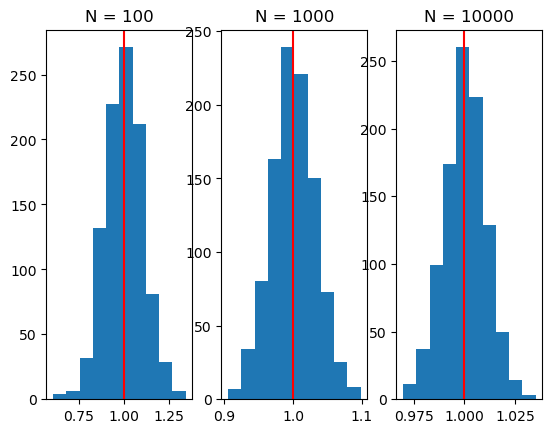

In [8]:
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 3) # initialize 3 subplots

# set global parameters for DGP
beta = 1
pi = np.array([[1]])
for N in [100, 1000, 10000]:
    # calculate IV a bunch of times
    beta_hats = [monteCarlo(N, beta, pi)[0].item() for i in range(1000)]
    # plot
    ax[counter].hist(beta_hats)
    ax[counter].set_title(f"N = {N}")
    ax[counter].axvline(x=1, color='r', label='True beta')

    # advance counter
    counter = counter + 1

### Estimated standard error of beta

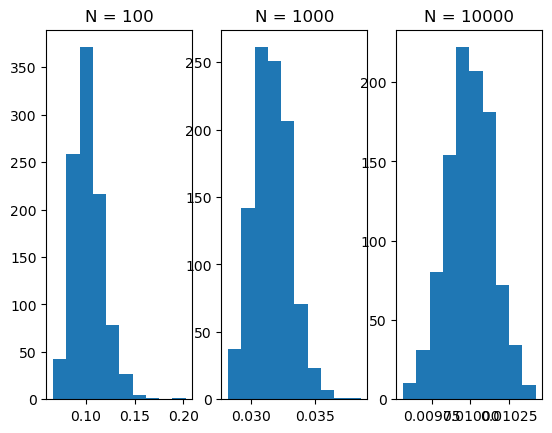

In [9]:
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 3) # initialize 3 subplots

# set global parameters for DGP
beta = 1
pi = np.array([[1]])
for N in [100, 1000, 10000]:
    # calculate IV a bunch of times
    se_beta_hat = [monteCarlo(N, beta, pi)[1].item() for i in range(1000)]
    # plot
    ax[counter].hist(se_beta_hat)
    ax[counter].set_title(f"N = {N}")
    # advance counter
    counter = counter + 1

### Size and power of the t-test

In [10]:
# N = 100
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(1000, 1, np.array([[1]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.648
Model:                            OLS   Adj. R-squared (uncentered):              0.648
Method:                 Least Squares   F-statistic:                              1840.
Date:                Mon, 17 Apr 2023   Prob (F-statistic):                   8.08e-229
Time:                        22:53:24   Log-Likelihood:                         -1452.4
No. Observations:                1000   AIC:                                      2907.
Df Residuals:                     999   BIC:                                      2912.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9717      0.023     42.898      0.000       0.927       1.016
==============================================================================
Omnibus:                        0.838   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.658   Jarque-Bera (JB):                0.826
Skew:                          -0.070   Prob(JB):                        0.662
Kurtosis:                       2.993   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# N = 1000
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(10000, 1, np.array([[1]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.669
Model:                            OLS   Adj. R-squared (uncentered):              0.669
Method:                 Least Squares   F-statistic:                          2.021e+04
Date:                Mon, 17 Apr 2023   Prob (F-statistic):                        0.00
Time:                        22:53:27   Log-Likelihood:                         -14146.
No. Observations:               10000   AIC:                                  2.829e+04
Df Residuals:                    9999   BIC:                                  2.830e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9976      0.007    142.154      0.000       0.984       1.011
==============================================================================
Omnibus:                        0.486   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.784   Jarque-Bera (JB):                0.482
Skew:                           0.017   Prob(JB):                        0.786
Kurtosis:                       3.001   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# N = 10000
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(10000, 1, np.array([[1]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.652
Model:                            OLS   Adj. R-squared (uncentered):              0.652
Method:                 Least Squares   F-statistic:                          1.873e+04
Date:                Mon, 17 Apr 2023   Prob (F-statistic):                        0.00
Time:                        22:53:27   Log-Likelihood:                         -14252.
No. Observations:               10000   AIC:                                  2.851e+04
Df Residuals:                    9999   BIC:                                  2.851e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9869      0.007    136.871      0.000       0.973       1.001
==============================================================================
Omnibus:                        0.685   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.649
Skew:                          -0.006   Prob(JB):                        0.723
Kurtosis:                       3.038   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Takeaways
<br>
Yes, a 95% confidence interval estimated by the 2SLS estimator above almost correctly covers 95% of our Monte Carlo draws. This coverage improves as N increases. 
<br>
<br>
For example:
<br>
1. When N = 1000: 
<br>
95% CI estimated by 2SLS estimator = [0.956,1.041]
<br>
95% of Monte Carlo draws = [0.9, 1.1]
<br>
<br>
2. When N = 10000: 
<br>
95% CI estimated by 2SLS estimator = [0.975,1.025]
<br>
95% of Monte Carlo draws = [0.971, 1.998]


## 2 (c)
Now let's iterate over $\pi$ instead of N, seeing how we do with varyingly weak instruments.
<br>
Note: We use sample size N = 1000 

### Estimated beta

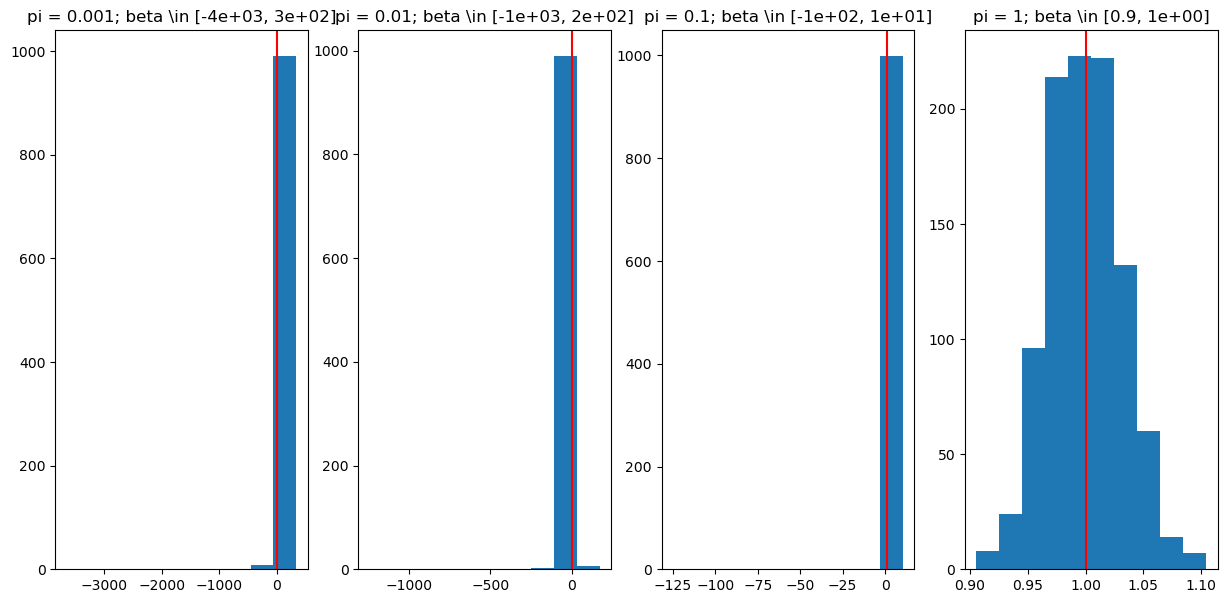

In [13]:
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 4, figsize=(15,7)) # initialize 3 subplots

# set global parameters for DGP
beta = 1
N = 1000

# start empty list to save to
beta_hats = []

for p in [0.001, 0.01, 0.1, 1]:
    # calculate IV a bunch of times
    beta_hats = np.array([monteCarlo(N, beta, np.array([[p]]))[0].item() for i in range(1000)])
    # some stats
    minbeta = beta_hats.min()
    maxbeta = beta_hats.max()
    # plot
    ax[counter].hist(beta_hats)
    ax[counter].set_title(f"pi = {p}; beta \in [{minbeta:.1}, {maxbeta:.1}]")
    ax[counter].axvline(x=1, color='r', label='True beta')

    # advance counter
    counter = counter + 1

### Estimated standard error of beta

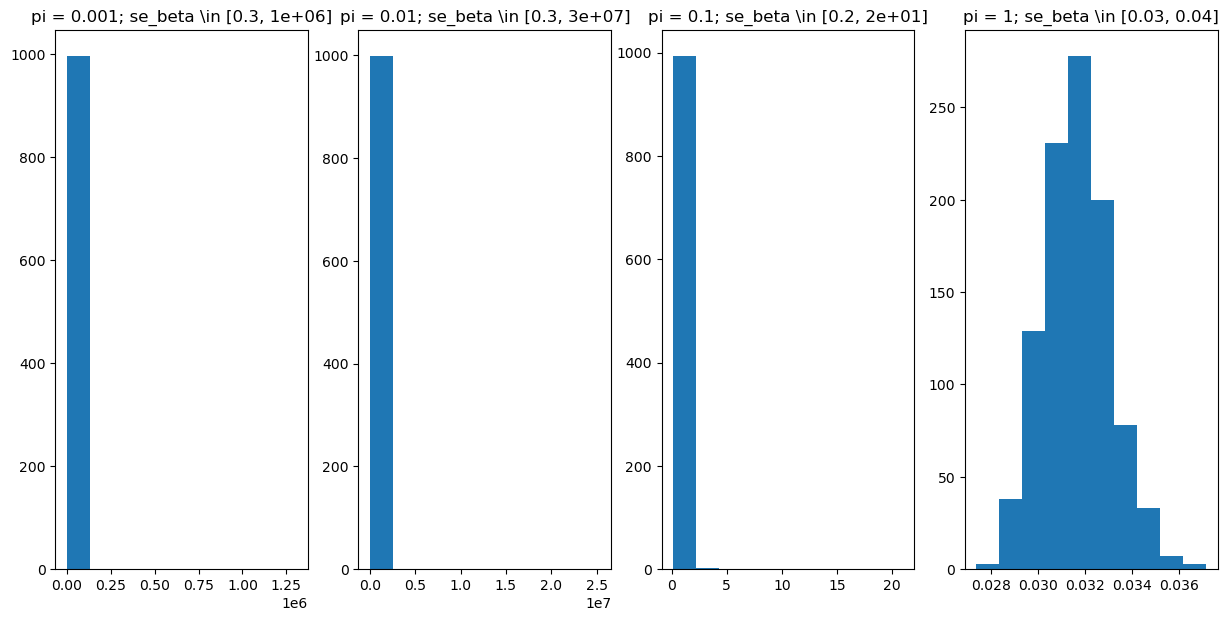

In [14]:
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 4, figsize=(15,7)) # initialize 3 subplots

# set global parameters for DGP
beta = 1
N = 1000

# start empty list to save to
se_beta_hat = []

for p in [0.001, 0.01, 0.1, 1]:
    # calculate IV a bunch of times
    se_beta_hat = np.array([monteCarlo(N, beta, np.array([[p]]))[1].item() for i in range(1000)])
    # some stats
    minvb = se_beta_hat.min()
    maxvb = se_beta_hat.max()
    # plot
    ax[counter].hist(se_beta_hat)
    ax[counter].set_title(f"pi = {p}; se_beta \in [{minvb:.1}, {maxvb:.1}]")

    # advance counter
    counter = counter + 1

### Size and power of the t-test

In [15]:
# p = 0.001
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(1000, 1, np.array([[0.001]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.506
Model:                            OLS   Adj. R-squared (uncentered):              0.506
Method:                 Least Squares   F-statistic:                              1024.
Date:                Mon, 17 Apr 2023   Prob (F-statistic):                   3.07e-155
Time:                        22:53:58   Log-Likelihood:                         -1381.8
No. Observations:                1000   AIC:                                      2766.
Df Residuals:                     999   BIC:                                      2770.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            17.9507      0.561     32.000      0.000      16.850      19.052
==============================================================================
Omnibus:                        3.824   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                3.790
Skew:                           0.151   Prob(JB):                        0.150
Kurtosis:                       3.005   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# p = 0.01
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(1000, 1, np.array([[0.01]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.517
Model:                            OLS   Adj. R-squared (uncentered):              0.517
Method:                 Least Squares   F-statistic:                              1070.
Date:                Mon, 17 Apr 2023   Prob (F-statistic):                   4.51e-160
Time:                        22:53:58   Log-Likelihood:                         -1388.0
No. Observations:                1000   AIC:                                      2778.
Df Residuals:                     999   BIC:                                      2783.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -15.1172      0.462    -32.704      0.000     -16.024     -14.210
==============================================================================
Omnibus:                        7.101   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.080
Skew:                          -0.179   Prob(JB):                       0.0290
Kurtosis:                       3.203   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# p = 0.1
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(1000, 1, np.array([[0.1]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.526
Model:                            OLS   Adj. R-squared (uncentered):              0.526
Method:                 Least Squares   F-statistic:                              1110.
Date:                Mon, 17 Apr 2023   Prob (F-statistic):                   3.08e-164
Time:                        22:53:59   Log-Likelihood:                         -1389.7
No. Observations:                1000   AIC:                                      2781.
Df Residuals:                     999   BIC:                                      2786.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.9945      0.240     33.311      0.000       7.524       8.465
==============================================================================
Omnibus:                        0.903   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.637   Jarque-Bera (JB):                0.943
Skew:                           0.072   Prob(JB):                        0.624
Kurtosis:                       2.954   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# p = 1
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(1000, 1, np.array([[1]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.644
Model:                            OLS   Adj. R-squared (uncentered):              0.643
Method:                 Least Squares   F-statistic:                              1805.
Date:                Mon, 17 Apr 2023   Prob (F-statistic):                   3.79e-226
Time:                        22:53:59   Log-Likelihood:                         -1444.6
No. Observations:                1000   AIC:                                      2891.
Df Residuals:                     999   BIC:                                      2896.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0083      0.024     42.491      0.000       0.962       1.055
==============================================================================
Omnibus:                        3.015   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.222   Jarque-Bera (JB):                3.082
Skew:                           0.069   Prob(JB):                        0.214
Kurtosis:                       3.235   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Takeaways
<br>
1. As pi -> 0 (i.e., the instrument 'Z' becomes weaker), our Monte Carlo simulations show that the estimates of beta become more biased and move away from the true value of beta. Additionally, the estimates become less precise, with the variance increasing as the instrument becomes weaker.  
<br>
<br>
2. Finally, we also notice that the 95% CI based on our 2SLS estimator (refer to the OLS regressions bove) does not cover 95% of our Monte Carlo draws for smaller values of pi. As pi -> 1, this coverage improves. For pi = 1, this coverage is almost precise. 
<br>
<br>
3. The above weak instrument problem (i.e., pi -> 0) does *not* go away even if we consider the estimates of beta with an asymptotic sample size (note: I ran the above code for N=10000 and N=100000 to look at the asymptotic case).

## Part 3

## 3 (a)

Note:
<br>
1. \beta = 1 
2. l = (1,2,3....) s.t. pi = (1,1/2,1/4....)
<br>
for l>1, this is an overidentified estimator

### Estimated beta

In [19]:
seq = [(1/2)**(n) for n in range(100)]
for l in range(1, 51): 
    p = np.c_[seq[0:l]]
 

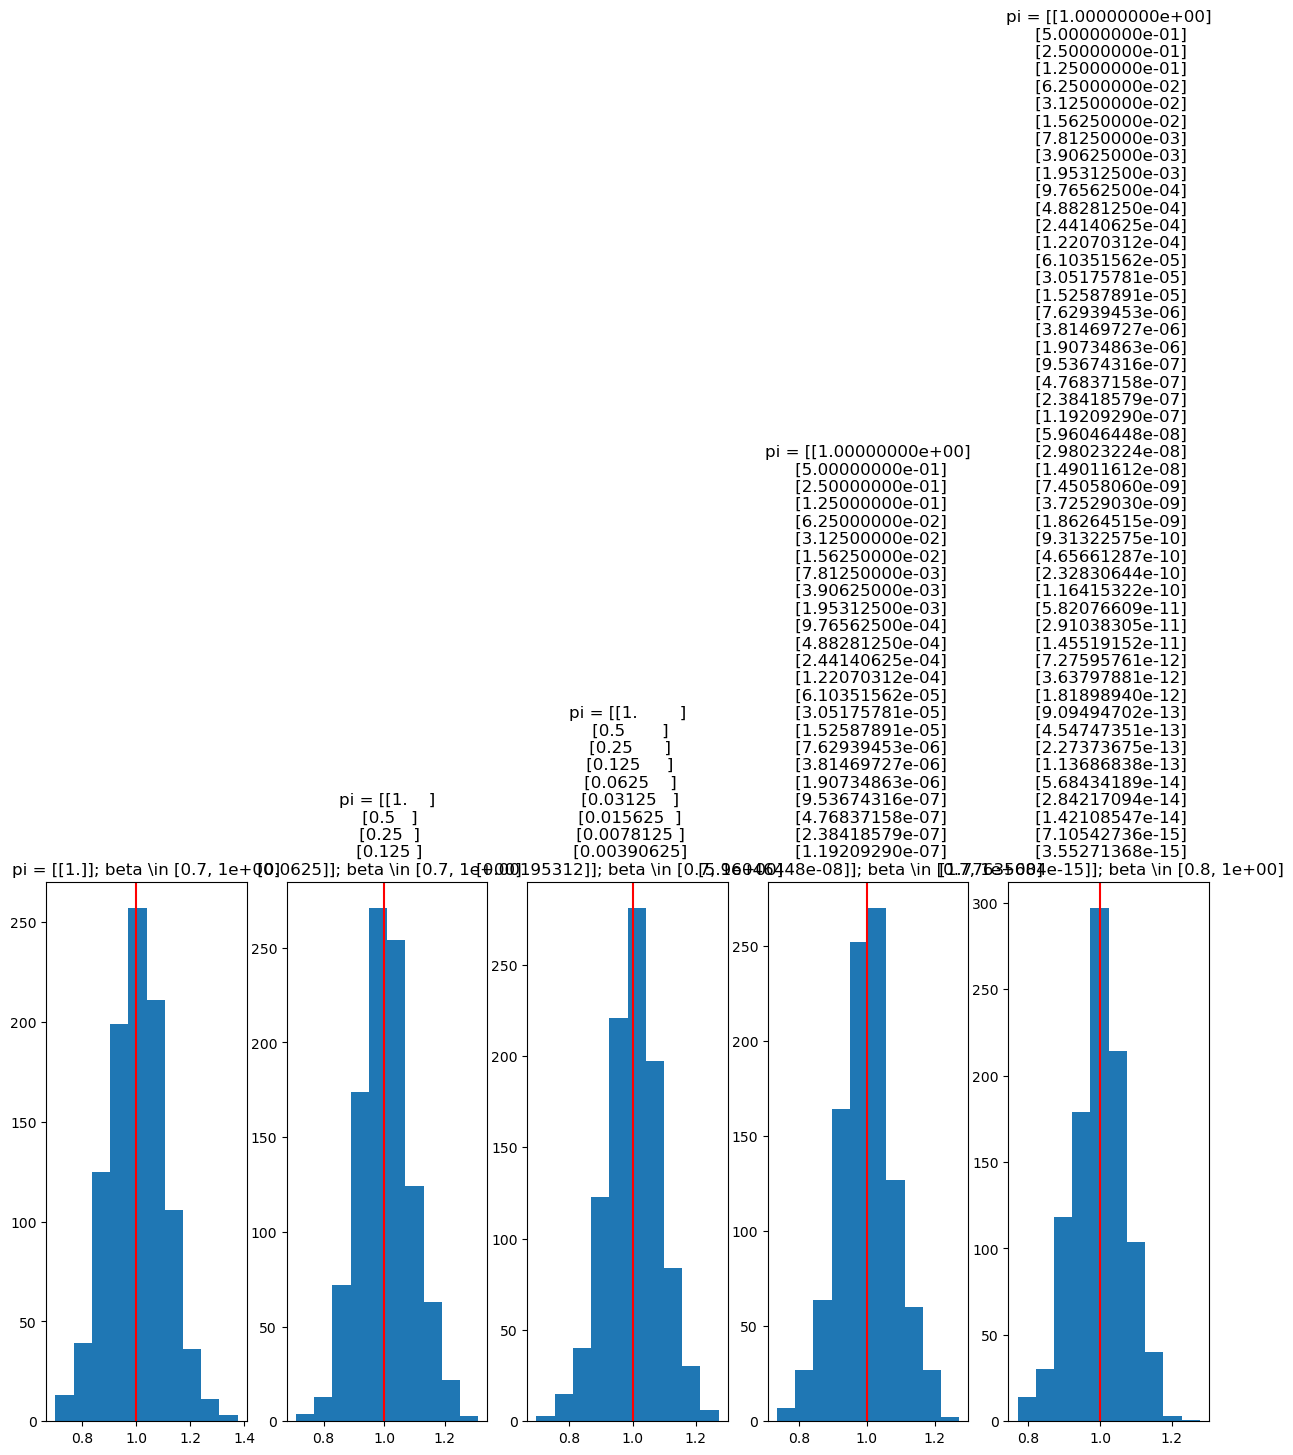

In [20]:
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 5, figsize=(15,7)) # initialize l subplots

# set global parameters for DGP
beta = 1
N = 100

# calculate IV a bunch of times
for l in range(1, 51): 
    p = np.c_[seq[0:l]]
    beta_hat_l = np.array([monteCarlo(N, beta, p)[0].item() for i in range(1000)])
    if l in [1,5,10,25,50]:
        minbeta = beta_hat_l.min()
        maxbeta = beta_hat_l.max()
        # plot
        ax[counter].hist(beta_hat_l)
        ax[counter].set_title(f"pi = {p}; beta \in [{minbeta:.1}, {maxbeta:.1}]")
        ax[counter].axvline(x=1, color='r', label='True beta')

        # advance counter
        counter = counter + 1
        

### Estimated standard error of beta

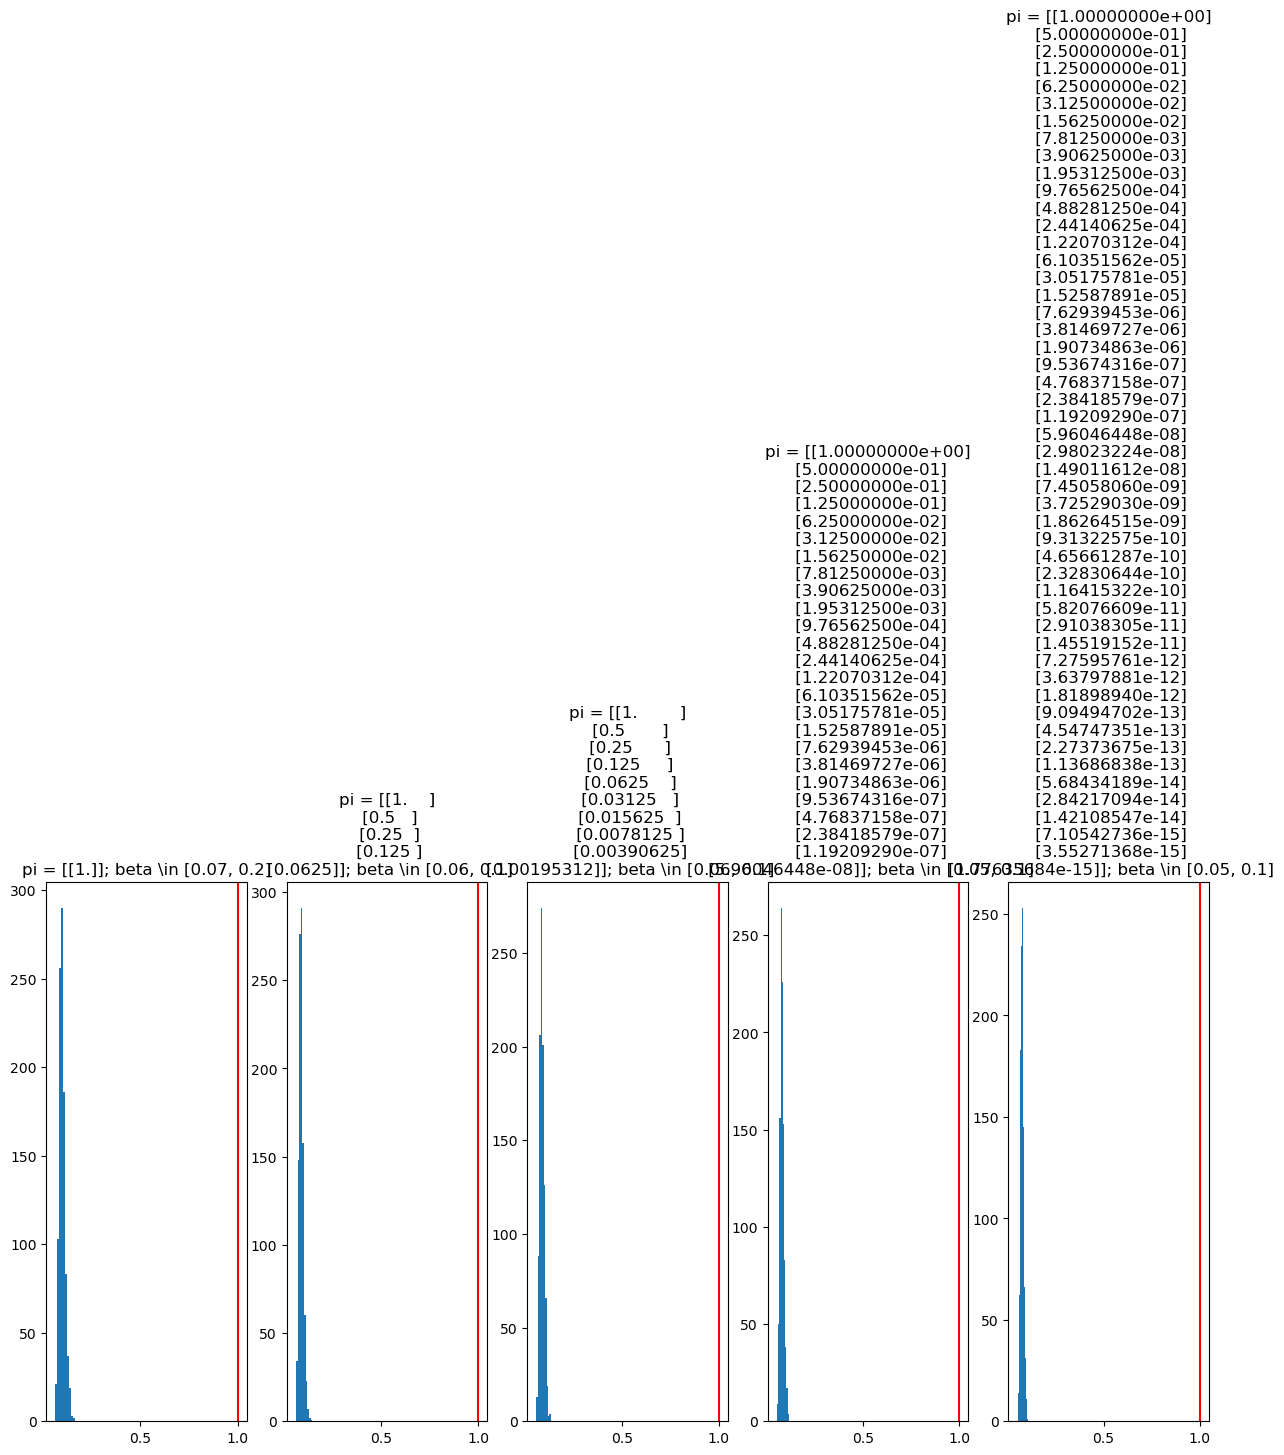

In [21]:
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 5, figsize=(15,7)) # initialize l subplots

# set global parameters for DGP
beta = 1
N = 100

# calculate IV a bunch of times
for l in range(1, 51): 
    p = np.c_[seq[0:l]]
    beta_hat_l = np.array([monteCarlo(N, beta, p)[1].item() for i in range(1000)])
    if l in [1,5,10,25,50]:
        minbeta = beta_hat_l.min()
        maxbeta = beta_hat_l.max()
        # plot
        ax[counter].hist(beta_hat_l)
        ax[counter].set_title(f"pi = {p}; beta \in [{minbeta:.1}, {maxbeta:.1}]")
        ax[counter].axvline(x=1, color='r', label='True beta')

        # advance counter
        counter = counter + 1
        

### Size and power of the t-test

In [ ]:
seq = [(1/2)**(n) for n in range(100)]
for l in [1,5,10,25,50]: 
    p = np.c_[seq[0:l]]
    from statsmodels.regression.linear_model import OLS
    y, X, Z = dgp(1000, 1, p)
    y = np.array(y)
    X = np.array(X)
    Z = np.array(Z)
    ZX = np.transpose(Z)@X
    ZX_inv = np.linalg.pinv(ZX)#using pseuodo-inverse
    Zy = np.transpose(Z)@y
    ZZ = np.transpose(Z)@Z
    ZZ_inv = np.linalg.pinv(ZZ)
    xhat_l = X@np.linalg.pinv(np.transpose(ZX)@ZZ_inv@ZX)@(np.transpose(ZX)@ZZ_inv@Zy)
    print()
    OLS(y,xhat_l).fit().summary()
   

### Takeaways
<br>

1. As the number of instruments, l, increases (l = 1,2,3...) we find that the precision of estimated beta does not improve very much. This could owe to the fact that additional instruments are weaker in their prediction of the regressor, X. Therefore, adding more instruments does not necessarily improve the precision of the estimated beta. 
<br>
<br>
2. As the number of instruments, l, increases (l = 1,2,3...), we also find that the coverage of our Monte Carlo draws (based on the 95% CI) are not very different.
<br>
<br>
3. Overall, if we compare (l>1) to the case where (l=1), we do not find any significant improvement. This result is intuitive as we explain in Takeaway 1 above (owing to successively weak instruments). 

## 3 (b)




1. Since the above result/inference in 3 (a) holds, we claim that the optimal number of instruments is 1 (l = 1) as the first instrument predicts X perfectly (pi = 1 when l = 1). Therefore, adding more instruments seems redundant if we are looking for the best precision in our estimates. 

##### ------ end of code ------